2024-05-25 19:01:30.364943: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 19:01:30.388772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 19:01:30.810246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


SRC: cloth3d++_subset/


2024-05-25 19:01:31.332755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 19:01:31.349283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 19:01:31.349423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Number of data used to train:
119856
Input shape: (4, 256, 256, 3)
Label shape: (4, 256, 256)
Learning rate: 1e-05
Epoch 1/3


2024-05-25 19:01:38.542201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-05-25 19:01:38.666050: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-05-25 19:01:38.666077: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-05-25 19:01:38.666166: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-25 19:01:40.745744: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x748f011bf040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-25 19:01:40.745765: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecuto

      6/Unknown - 14s 271ms/step - loss: 0.2459 - mae: 0.4759WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1136s vs `on_train_batch_end` time: 0.1403s). Check your callbacks.
7491/7491 [==============================] - 2108s 280ms/step - loss: 0.0064 - mae: 0.0331 - val_loss: 0.0066 - val_mae: 0.0262
Epoch 2/3


2024-05-25 19:36:43.638541: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13452515745927437273
2024-05-25 19:36:43.638573: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 9526819693883586728
2024-05-25 19:36:43.638586: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1360813407480552970


7491/7491 [==============================] - 2096s 280ms/step - loss: 0.0027 - mae: 0.0163 - val_loss: 0.0050 - val_mae: 0.0220
Epoch 3/3
7491/7491 [==============================] - 2096s 280ms/step - loss: 0.0019 - mae: 0.0129 - val_loss: 0.0042 - val_mae: 0.0195


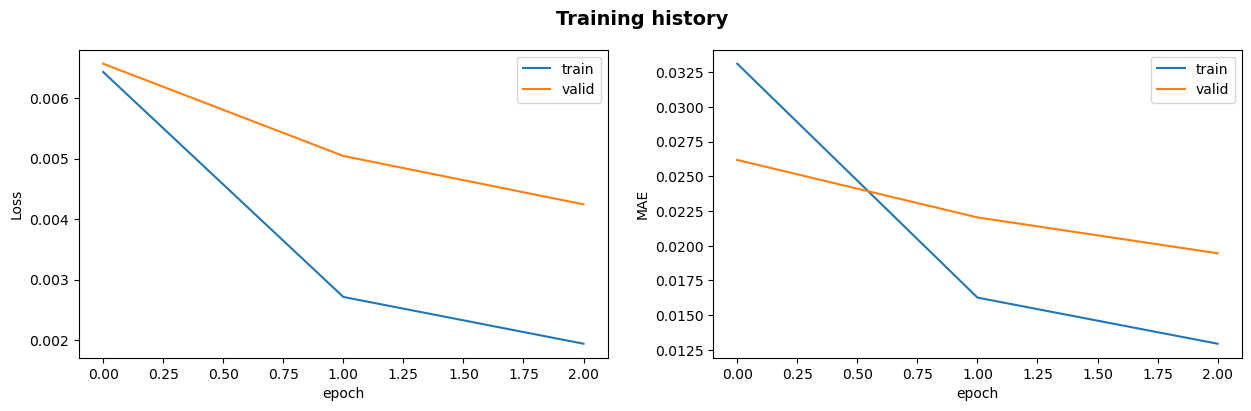

Best validation loss: 0.004244046751409769 at epoch 2


In [1]:
# %%
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
import os
from PIL import Image



# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

n_epochs = 3
batch_size = 4

# %%
class TFRecordDataHandler:
    def __init__(self, tfrecord_file, batch_size=32, shuffle=True, augment=False):
        self.tfrecord_file = tfrecord_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

    def _parse_function(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'depth': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth_height': tf.io.FixedLenFeature([], tf.int64),
            'depth_width': tf.io.FixedLenFeature([], tf.int64)
        }
        parsed_features = tf.io.parse_single_example(proto, feature_description)

        image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
        depth = tf.io.decode_raw(parsed_features['depth'], tf.float32)

        height = parsed_features['height']
        width = parsed_features['width']

        image = tf.reshape(image, [height, width, 3])
        depth = tf.reshape(depth, [parsed_features['depth_height'], parsed_features['depth_width']])

        return image, depth

    def _normalize(self, image, depth):
        # Convert image to float for processing and normalize to range [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        # Create a mask where depth values are greater than zero
        depth_mask = depth > 0

        # Normalize depth based on masked regions
        # Calculate the mean of the depth where it is greater than zero
        depth_values = tf.boolean_mask(depth, depth_mask)
        depth_mean = tf.reduce_mean(depth_values)

        # Subtract the mean from the depth values where mask is true
        depth = tf.where(depth_mask, depth - depth_mean, depth)

        # Set depth values less than 0 to 0 after subtraction
        depth = tf.maximum(depth, 0)

        # Prepare the mask for RGB image normalization
        mask = tf.tile(tf.expand_dims(depth_mask, axis=-1), [1, 1, 3])

        # Masked image for mean and std deviation calculation
        masked_image = tf.boolean_mask(image, mask)
        mean, variance = tf.nn.moments(masked_image, axes=[0])
        std_dev = tf.sqrt(variance + 1e-6)  # Adding epsilon to avoid division by zero

        # Apply the mask to image normalization
        normalized_image = tf.where(
            mask,
            (image - mean) / std_dev,
            image  # Preserve original pixels where mask is False
        )

        return normalized_image, depth

    def _augment(self, image, depth):
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            depth = tf.image.flip_left_right(tf.expand_dims(depth, axis=-1))
            depth = tf.squeeze(depth, axis=-1)
        image = tf.image.random_brightness(image, max_delta=0.1)
        return image, depth

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self._normalize, num_parallel_calls=tf.data.AUTOTUNE)

        if self.augment:
            dataset = dataset.map(self._augment, num_parallel_calls=tf.data.AUTOTUNE)

        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    
    def get_num_samples(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        count = 0
        for _ in dataset:
            count += 1
        return count


# %%

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr):.6f}")

class TensorBoardLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir='./logs'):
        super(TensorBoardLearningRateLogger, self).__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        with self.file_writer.as_default():
            tf.summary.scalar('learning_rate', tf.keras.backend.get_value(lr), step=epoch)

# %%
def visualize_hist(history, show=True, filename=None, title='Training history'):
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()

    if filename is not None:
        fig.savefig(filename)


# %%
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)

        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)

        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate

        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }

# %%
# Parameters
initial_learning_rate = 1e-5
target_learning_rate = 1e-2
verbose = 1
shuffle = True
checkpoint = './best_model.h5'

trainloader = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True)
valloader = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False)
train_dg = trainloader.load_dataset()
validation_dg = valloader.load_dataset()

num_samples_train = trainloader.get_num_samples()

print('Number of data used to train:')
print(num_samples_train * batch_size)
# print('')

for x, y in train_dg.take(1):
    print("Input shape:", x.shape)  # Should be (batch_size, height, width, channels)
    print("Label shape:", y.shape)  # Should be (batch_size, ...) depending on your task


total_steps = num_samples_train * n_epochs


for wu_ratio in [0.1]:

    warmup_steps = int(wu_ratio * total_steps)

    experiment_name = f'lr_decay_{initial_learning_rate}_{target_learning_rate}_wu_ratio_{wu_ratio}'

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(".logs", experiment_name))
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join(".logs", experiment_name))


    # Create the learning rate schedule
    lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                        stack_num_down=2, stack_num_up=1,
                        activation='GELU', output_activation='Sigmoid', 
                        batch_norm=True, pool='max', unpool=False, name='unet')

    print('Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    # es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    # mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

    # training the model and saving the history
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=2, use_multiprocessing=True,
                        callbacks=[tensorboard_callback, tensorboard_lr_logger])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()

# %%